In [26]:

import jax.numpy as np
import jax.random as npr
import matplotlib.pyplot as plt

In [27]:
%load_ext autoreload
%autoreload 2

from ssm.models.lds import _StandardLDS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:

def random_rotation(n, theta=None, key=npr.PRNGKey(0)):
    
    import numpy as np
    
    key1, key2 = npr.split(key)
    
    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * np.pi * npr.uniform(key1)

    if n == 1:
        return npr.uniform(key1) * np.eye(1)

    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    out = np.eye(n)
    out[:2, :2] = rot
    q = np.linalg.qr(npr.uniform(key2, shape=(n, n)))[0]
    return q.dot(out).dot(q.T)


def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    """Utility to visualize the dynamics for a 2 dimensional dynamical system.
    Args
    ----
        dynamics_matrix: 2x2 numpy array. "A" matrix for the system.
        bias_vector: "b" vector for the system. Has size (2,).
        mins: Tuple of minimums for the quiver plot.
        maxs: Tuple of maximums for the quiver plot.
        npts: Number of arrows to show.
        axis: Axis to use for plotting. Defaults to None, and returns a new axis.
        kwargs: keyword args passed to plt.quiver.
    Returns
    -------
        q: quiver object returned by pyplot
    """
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    xy_grid = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    return q

In [41]:
obs_dim = 10
hidden_dim = 2

true_lds = _StandardLDS(obs_dim, hidden_dim)

In [46]:
key = npr.PRNGKey(0)
key1, key2, key3, key4, key5 = npr.split(key, 5)

A0 = .99 * random_rotation(hidden_dim, theta=np.pi/20, key=key1)
S = np.arange(1, hidden_dim+1)
R = np.linalg.svd(npr.normal(key2, shape=(hidden_dim, hidden_dim)))[0] * S
A = R.dot(A0).dot(np.linalg.inv(R))
b = npr.normal(key3, shape=(hidden_dim,))

C = npr.normal(key4, shape=(obs_dim, hidden_dim))
d = npr.normal(key5, shape=(obs_dim,))

In [70]:
# set the dynamics of our LDS object

true_lds.transition_matrix = A
true_lds.hidden_bias = b
true_lds.emission_scale_tril = np.identity(hidden_dim) * 0.25

true_lds.emission_matrix = C
true_lds.output_bias = d
true_lds.emission_scale_tril = np.identity(obs_dim) * 0.25

true_lds.initial_mean = np.ones(hidden_dim)
true_lds.initial_scale_tril = np.identity(hidden_dim) * 0.25

In [75]:
time_bins = 200
key = npr.PRNGKey(0)

states, emissions = true_lds.sample(key=key, num_steps=time_bins)

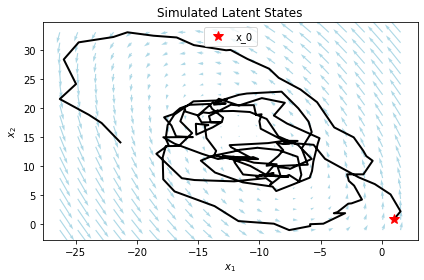

In [105]:
# Plot the dynamics vector field
q = plot_dynamics_2d(A, 
                     bias_vector=b,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="lightblue")

plt.plot(states[:,0], states[:,1], '-k', lw=2)
plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="x_0")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()
plt.legend()
plt.show()

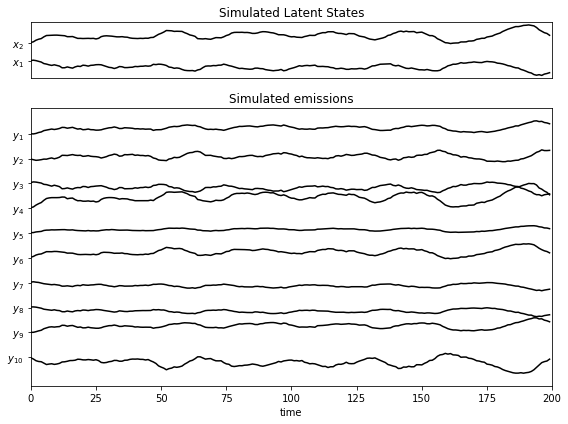

In [106]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, obs_dim/hidden_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(hidden_dim):
    plt.plot(states[:, d] + lim * d, '-k')
plt.yticks(np.arange(hidden_dim) * lim, ["$x_{}$".format(d+1) for d in range(hidden_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(emissions).max()
plt.subplot(gs[1])
for n in range(obs_dim):
    plt.plot(emissions[:, n] - lim * n, '-k')
plt.yticks(-np.arange(obs_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(obs_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Simulated emissions")
plt.tight_layout()